In [142]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional, Conv1D, Concatenate
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

DIRECTORY = '.'
SUMMARY_PATH = 'NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

glove_word2vec = 'NLP_app/word2vec_perso.txt'
our_word2vec = 'NLP_app/word2vec_perso.txt'

# Util
Some useful functions. <br>
You don’t really need to understand them, these are utilities functions.
 

In [4]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('./', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('./', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    
    # Uses only funds in rag_preds, which are funds with the 3 relevant strategies
    rag_preds = pd.read_csv("rag_predictions.csv")
    relevant_funds = list(rag_preds['fund_name'])
    
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        if fund_name in relevant_funds:
            texts.append(summary)
            fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [5]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [6]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)
# The reading function can take several minutes depending on your internet connection.
# The reading function store the data in the cache so that rerunning the cell should be must faster.

In [7]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence

More cleaning could be done. We could for instance remove the tokens that have less than 3 letters or all the tokens that contains non-letter characters. <br>
Then we create one long list of tokens by tokenizing all the summaries with our "tokenizer" function and concatenating all the summaries.


In [8]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [9]:
print('bluechip' in text_words)

False


In [10]:
print(text_words[:20])

['investment' 'objective' 'thrivent' 'partner' 'healthcare' 'portfolio'
 'portfolio' 'seeks' 'long-term' 'capital' 'growth' 'fees' 'expenses'
 'table' 'describes' 'fees' 'expenses' 'may' 'pay' 'buy']


### 3_ Process Skip-Gram model Input

In [11]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 3.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).


In [12]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

We start by building a dictionary that contains our vocabulary and the number of occurrences of each words : <u>count</u>

In [13]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

Then, we give a unique id to each words in our vocabulary.

In [14]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [15]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3201


The length of the vocabulary corresponds to the 5000 most common words of our corpus minus the stop words. <br>
Then we create <u>data</u> which is simply the full tokenized corpus (text_words) where we filter out the words that are not in our vocabulary and we replace the actual words by their id.


In [16]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [17]:
print(data[:20])

[3, 126, 3118, 446, 1778, 7, 7, 230, 270, 65, 91, 12, 9, 52, 346, 12, 9, 2, 66, 180]


We create a function that translate a word index to its one-hot representation (vector of zero with 1 in the word id position)

In [18]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [19]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### 4_ Train the skip-gram model
We are ready to create and train the model.

In [20]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [21]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [22]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3201)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3201)           │       163,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,351 (1.23 MB)

 Trainable params: 323,351 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
6392/6392 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 0.0610
Epoch 2/2
6392/6392 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - loss: 0.0024


<h3>5_ Use the encoder to vectorize</h3><br>
The autoencoder has been trained, we can now use the matrix and bias of the encoder (input + hidden layer) to build our word representations !

In [24]:
# Create the Vectorizer function (prediciton of the encoder)
def vectorize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [25]:
# Create the word2vec dictionary
word2vec = {w : vectorize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [26]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec)

# C- Sentence extraction

<h3> 1_ Create a knowledge base </h3>

In [43]:
equity_keywords = [
    "equity", "equities", "stock", "stocks", "shares", "common", "capital",
    "appreciation", "growth", "dividends", "midcap",
    "technology", "healthcare", "consumer", "industrials", "portfolio"
]
fixed_income_keywords = [
    "bond", "bonds", "debt", "coupon", "yield", "duration", "interest", "income",
    "fixed", "maturity", "treasury", "municipal", "corporate", "principal", "credit", "rates", "stable"
]
balanced_keywords = [
    "balanced", "diversified", "allocation", "blend", "mix", "strategy",
    "equities", "bonds", "stocks", "fixed", "income", "growth", "capital", 
    "preservation", "stability", "moderate", "hybrid", "rebalancing"
]

In [65]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [66]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [67]:
#word2vec = load_word2vec(our_word2vec)
eq_knowledge_base = create_knowledge_base(5, word2vec, equity_keywords)
fi_knowledge_base = create_knowledge_base(5, word2vec, fixed_income_keywords)
bal_knowledge_base = create_knowledge_base(5, word2vec, balanced_keywords)

In [68]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv('rag_predictions.csv')
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()

In [69]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [76]:
df['eq_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], eq_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['fi_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], fi_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['bal_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], bal_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [77]:
df.to_csv("dataset.csv")

## Making the Model

In [139]:
X = df[['eq_sentences', 'fi_sentences', 'bal_sentences']]
for col in ['eq_sentences', 'fi_sentences', 'bal_sentences']:
    X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))

y = df['Predicted Investment Strategy'].values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


/var/folders/jx/vhdxb7ks06710zlsb29bkz000000gn/T/ipykernel_39112/2951265711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))


In [146]:
# num_words - Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
# maxlen - Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
# word_dimension - dimension of our word vectors.
def run_CNN(num_words, maxlen, word_dimension):    
    word2vec_g = word2vec
    tokenizer_eq = Tokenizer(num_words=num_words)
    tokenizer_fi = Tokenizer(num_words=num_words)
    tokenizer_bal = Tokenizer(num_words=num_words)

    # Fit on texts
    tokenizer_eq.fit_on_texts(X['eq_sentences'])
    tokenizer_fi.fit_on_texts(X['fi_sentences'])
    tokenizer_bal.fit_on_texts(X['bal_sentences'])
    word_index_eq = tokenizer_eq.word_index
    word_index_fi = tokenizer_fi.word_index
    word_index_bal = tokenizer_bal.word_index

    # Convert texts to sequences
    seq_eq = tokenizer_eq.texts_to_sequences(X['eq_sentences'])
    seq_fi = tokenizer_fi.texts_to_sequences(X['fi_sentences'])
    seq_bal = tokenizer_bal.texts_to_sequences(X['bal_sentences'])

    # Pad sequences to uniform length
    X_eq = pad_sequences(seq_eq, maxlen=maxlen, padding='post')
    X_fi = pad_sequences(seq_fi, maxlen=maxlen, padding='post')
    X_bal = pad_sequences(seq_bal, maxlen=maxlen, padding='post')

    # First split: train + temp (temp will later be split into val and test)
    X_eq_train, X_eq_temp, X_fi_train, X_fi_temp, X_bal_train, X_bal_temp, y_train, y_temp = train_test_split(
        X_eq, X_fi, X_bal, y, test_size=0.3, random_state=42
    )

    # Second split: temp → val and test (e.g., 15% each)
    X_eq_val, X_eq_test, X_fi_val, X_fi_test, X_bal_val, X_bal_test, y_val, y_test = train_test_split(
        X_eq_temp, X_fi_temp, X_bal_temp, y_temp, test_size=0.5, random_state=42
    )

    embedding_matrix_eq = np.zeros((len(word_index_eq) + 1, word_dimension))
    for word, i in word_index_eq.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_eq[i] = embedding_vector

    embedding_matrix_fi = np.zeros((len(word_index_fi) + 1, word_dimension))
    for word, i in word_index_fi.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_fi[i] = embedding_vector
            
    embedding_matrix_bal = np.zeros((len(word_index_bal) + 1, word_dimension))
    for word, i in word_index_bal.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_bal[i] = embedding_vector

    def create_CNN_branch(input_shape, embedding_matrix, name_prefix="input"):
        input_layer = Input(shape=input_shape, name=f"{name_prefix}_input")

        x = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=input_shape[0],
            trainable=False,
            name=f"{name_prefix}_embedding"
        )(input_layer)

        x = Conv1D(64, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Conv1D(32, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Flatten()(x)
        return input_layer, x

    def create_CNN_model_multi_input(embedding_eq, embedding_fi, embedding_bal, maxlen):
        # Each branch
        eq_input, eq_branch = create_CNN_branch((maxlen,), embedding_eq, "eq")
        fi_input, fi_branch = create_CNN_branch((maxlen,), embedding_fi, "fi")
        bal_input, bal_branch = create_CNN_branch((maxlen,), embedding_bal, "bal")

        # Merge
        merged = Concatenate()([eq_branch, fi_branch, bal_branch])
        x = Dense(128, activation='relu')(merged)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        model = Model(inputs=[eq_input, fi_input, bal_input], outputs=output)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    CNN_model = create_CNN_model_multi_input(embedding_matrix_eq, embedding_matrix_fi, embedding_matrix_bal, maxlen)

    CNN_history = CNN_model.fit(
        [X_eq_train, X_fi_train, X_bal_train], y_train,
        validation_data=([X_eq_val, X_fi_val, X_bal_val], y_val),
        epochs=10,
        batch_size=32
    )

    acc = CNN_history.history['accuracy']
    val_acc = CNN_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Predict labels
    y_pred = CNN_model.predict([X_eq_test, X_fi_test, X_bal_test])
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Balanced', 'Equity', 'Fixed Income'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()





Num_words: 1500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4636 - loss: 1.1220 - val_accuracy: 0.5217 - val_loss: 1.0342
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5379 - loss: 1.0936 - val_accuracy: 0.5217 - val_loss: 1.0344
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5548 - loss: 1.0148 - val_accuracy: 0.5217 - val_loss: 1.0072
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5161 - loss: 1.0161 - val_accuracy: 0.5217 - val_loss: 1.0006
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5982 - loss: 0.9629 - val_accuracy: 0.5217 - val_loss: 1.0054
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5473 - loss: 0.9925 - val_accuracy: 0.5217 - val_loss: 0.9958
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5365 - loss: 1.0066 - val_accuracy: 0.5217 - val_loss: 0.9717
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5056 - loss: 1.0038 - val_accuracy: 0.5217 - val_loss: 0.

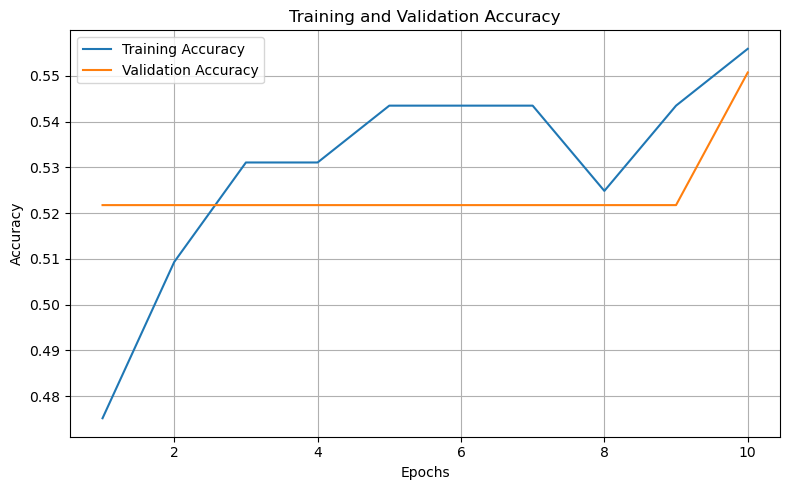

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


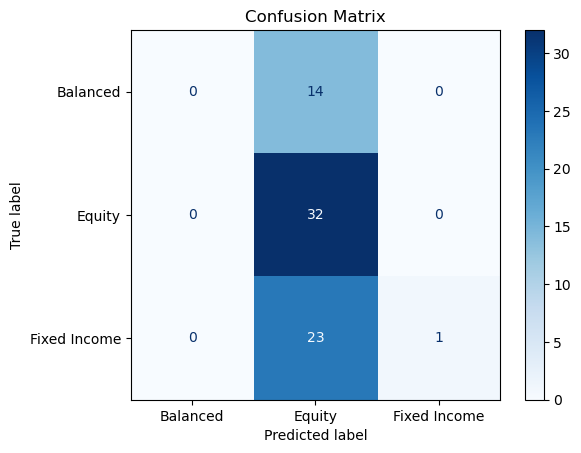




Num_words: 1500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4715 - loss: 1.0614 - val_accuracy: 0.5217 - val_loss: 0.9810
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5433 - loss: 0.9970 - val_accuracy: 0.5217 - val_loss: 0.9755
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5603 - loss: 0.9680 - val_accuracy: 0.5217 - val_loss: 0.9449
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5548 - loss: 0.9462 - val_accuracy: 0.5942 - val_loss: 0.9009
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6414 - loss: 0.8769 - val_accuracy: 0.6232 - val_loss: 0.8694
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6111 - loss: 0.8848 - val_accuracy: 0.6232 - val_loss: 0.8873
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6594 - loss: 0.8497 - val_accuracy: 0.6522 - val_loss: 0.8508
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6318 - loss: 0.8522 - val_accuracy: 0.6812 - val_loss: 0.

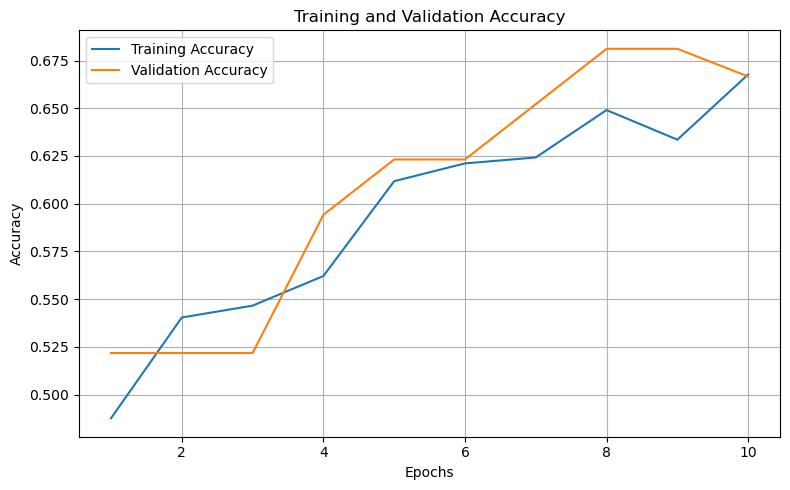

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


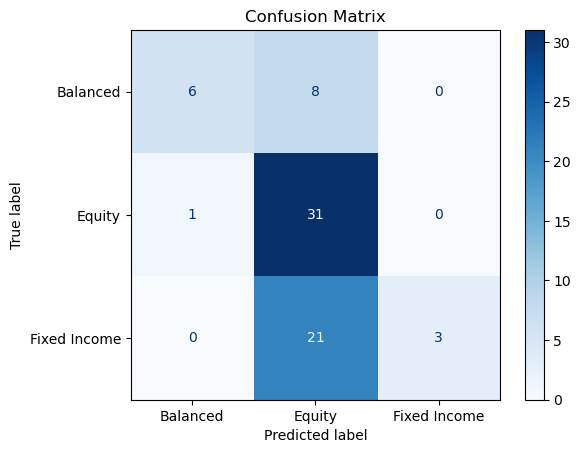




Num_words: 1500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4633 - loss: 1.1094 - val_accuracy: 0.5217 - val_loss: 0.9839
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5427 - loss: 1.0246 - val_accuracy: 0.5217 - val_loss: 0.9520
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5216 - loss: 0.9908 - val_accuracy: 0.5217 - val_loss: 0.9553
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5219 - loss: 1.0144 - val_accuracy: 0.5652 - val_loss: 0.9058
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5491 - loss: 0.9443 - val_accuracy: 0.5217 - val_loss: 0.9204
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6045 - loss: 0.9273 - val_accuracy: 0.5942 - val_loss: 0.8422
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5955 - loss: 0.8599 - val_accuracy: 0.6522 - val_loss: 0.8208
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6833 - loss: 0.8322 - val_accuracy: 0.6667 - val_loss: 0.

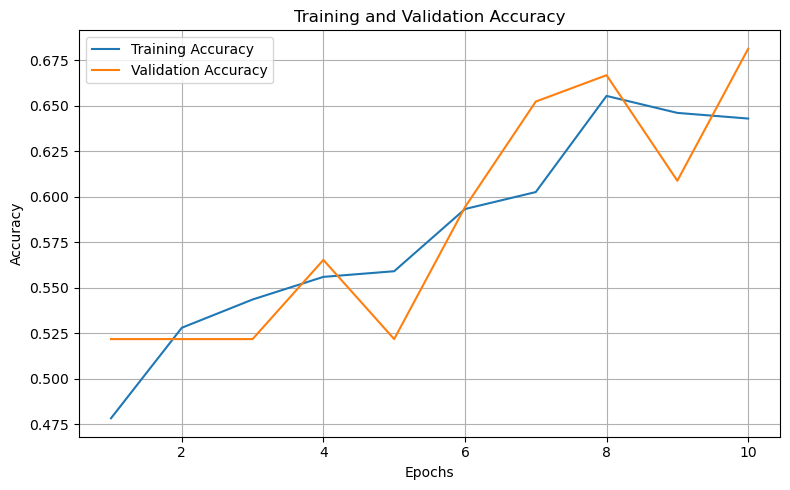

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


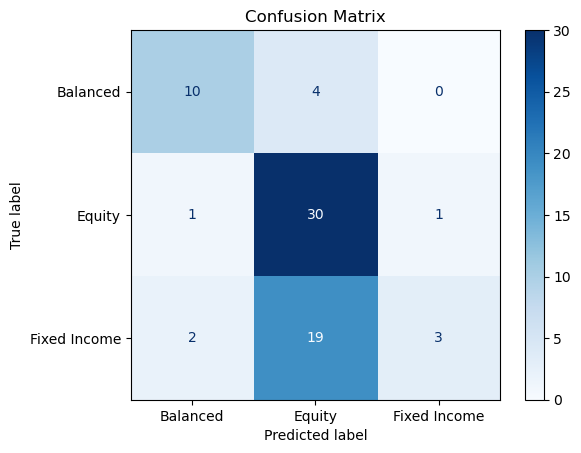




Num_words: 1500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4613 - loss: 1.1413 - val_accuracy: 0.5217 - val_loss: 0.9895
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5553 - loss: 0.9929 - val_accuracy: 0.5217 - val_loss: 0.9646
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5901 - loss: 0.9650 - val_accuracy: 0.5652 - val_loss: 0.9438
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5474 - loss: 0.9497 - val_accuracy: 0.5652 - val_loss: 0.9201
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5609 - loss: 0.9422 - val_accuracy: 0.5797 - val_loss: 0.8793
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5669 - loss: 0.9174 - val_accuracy: 0.5652 - val_loss: 0.9097
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5615 - loss: 0.9514 - val_accuracy: 0.6087 - val_loss: 0.8522
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6548 - loss: 0.8193 - val_accuracy: 0.6232 - val_loss: 0.

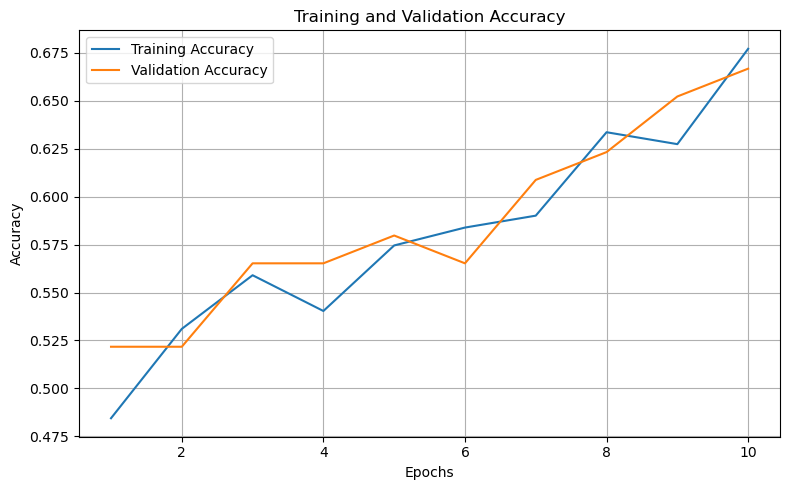

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


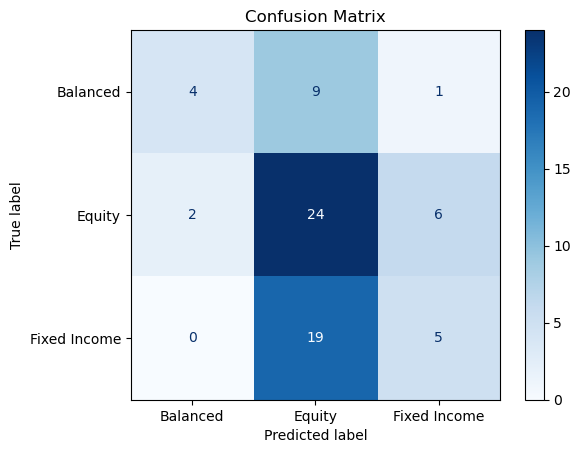




Num_words: 2500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4274 - loss: 1.0914 - val_accuracy: 0.5217 - val_loss: 1.0117
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5382 - loss: 1.0215 - val_accuracy: 0.5217 - val_loss: 1.0163
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4683 - loss: 1.0206 - val_accuracy: 0.5217 - val_loss: 1.0130
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5490 - loss: 1.0227 - val_accuracy: 0.5217 - val_loss: 0.9932
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5591 - loss: 0.9858 - val_accuracy: 0.5217 - val_loss: 0.9826
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5341 - loss: 1.0163 - val_accuracy: 0.5217 - val_loss: 0.9864
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5344 - loss: 0.9984 - val_accuracy: 0.5217 - val_loss: 0.9674
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5817 - loss: 0.9349 - val_accuracy: 0.5217 - val_loss: 0.

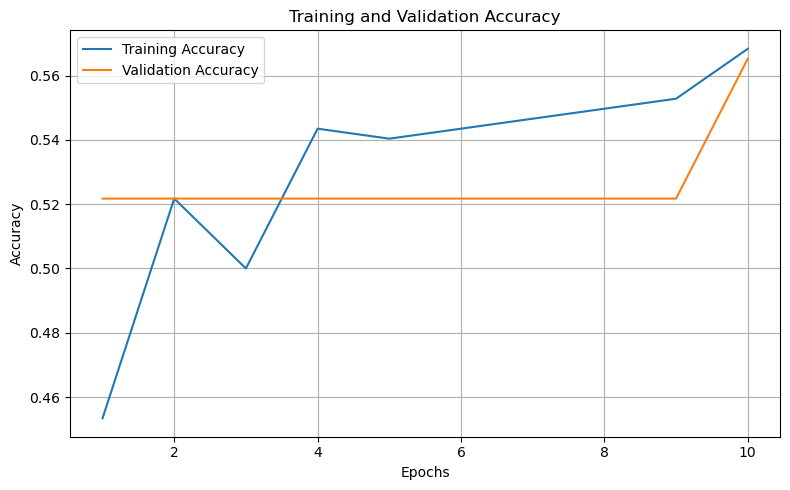

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


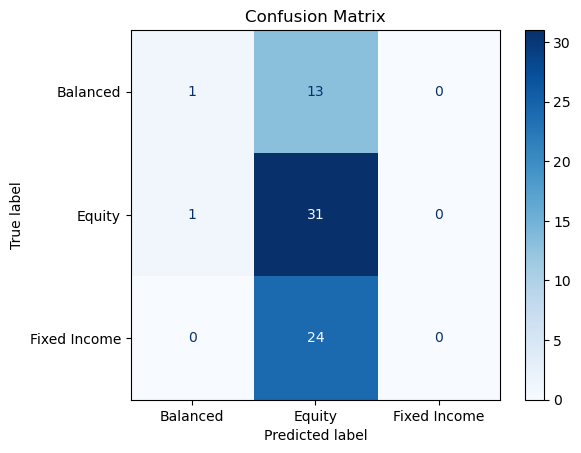




Num_words: 2500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4274 - loss: 1.1236 - val_accuracy: 0.5217 - val_loss: 1.0150
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4842 - loss: 1.0581 - val_accuracy: 0.5217 - val_loss: 1.0040
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5612 - loss: 0.9997 - val_accuracy: 0.5217 - val_loss: 1.0149
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.0055 - val_accuracy: 0.5217 - val_loss: 0.9732
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5614 - loss: 0.9884 - val_accuracy: 0.5362 - val_loss: 0.9656
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5590 - loss: 0.9345 - val_accuracy: 0.5217 - val_loss: 0.9076
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5792 - loss: 0.9028 - val_accuracy: 0.6522 - val_loss: 0.9053
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6088 - loss: 0.9005 - val_accuracy: 0.6232 - val_loss: 0.

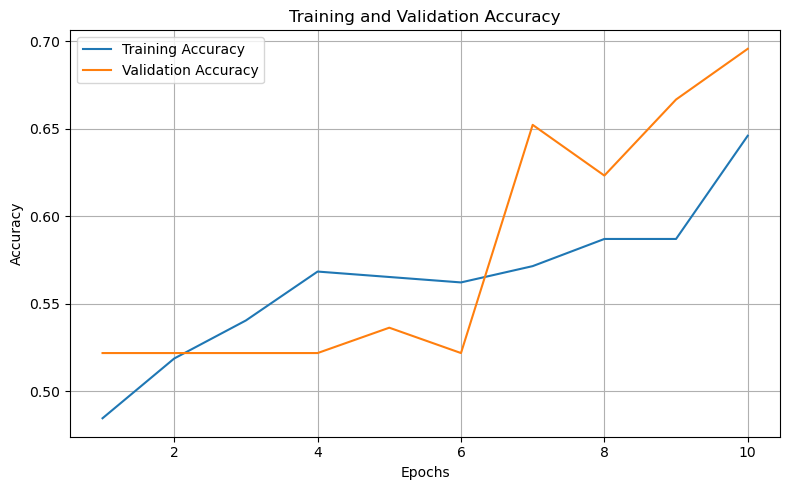

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


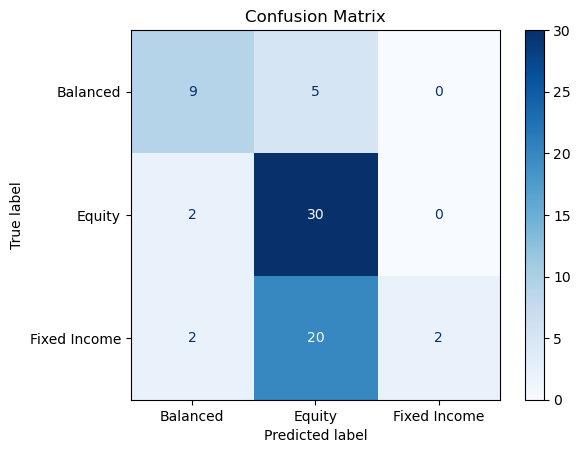




Num_words: 2500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4685 - loss: 1.0780 - val_accuracy: 0.5217 - val_loss: 1.0013
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5234 - loss: 1.0148 - val_accuracy: 0.5217 - val_loss: 0.9551
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5499 - loss: 0.9946 - val_accuracy: 0.5217 - val_loss: 0.9742
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5616 - loss: 0.9249 - val_accuracy: 0.5652 - val_loss: 0.9422
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5579 - loss: 0.9554 - val_accuracy: 0.5217 - val_loss: 0.9291
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5362 - loss: 0.9400 - val_accuracy: 0.6377 - val_loss: 0.8813
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6047 - loss: 0.8688 - val_accuracy: 0.6087 - val_loss: 0.8311
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6747 - loss: 0.8182 - val_accuracy: 0.6522 - val_loss: 0.

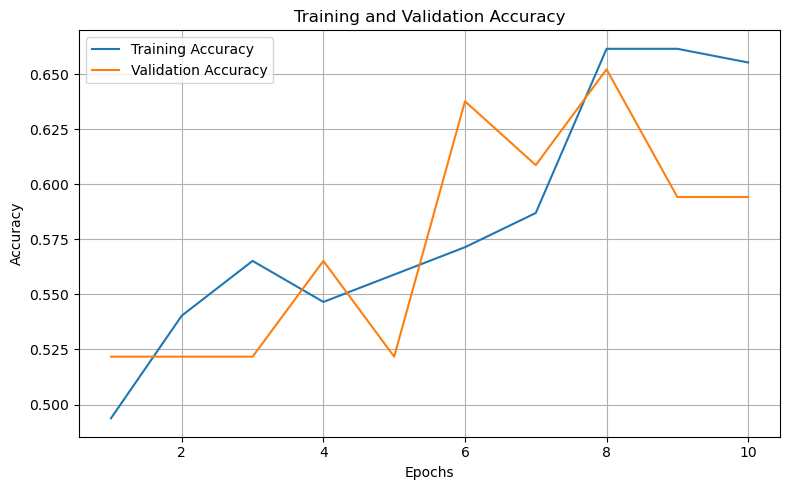

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


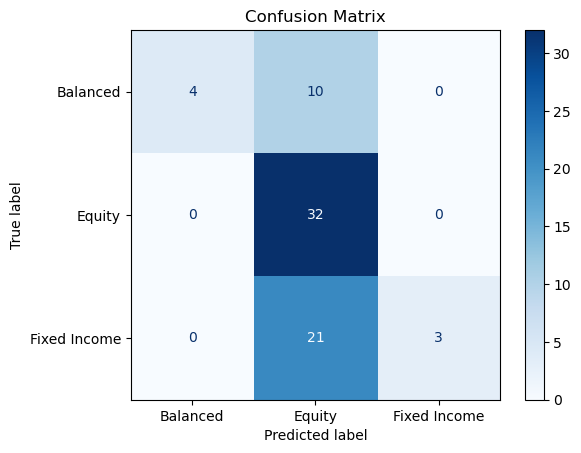




Num_words: 2500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4928 - loss: 1.0663 - val_accuracy: 0.5217 - val_loss: 1.0057
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5315 - loss: 1.0416 - val_accuracy: 0.5217 - val_loss: 0.9697
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5577 - loss: 0.9850 - val_accuracy: 0.5217 - val_loss: 0.9447
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5415 - loss: 0.9599 - val_accuracy: 0.5217 - val_loss: 0.9163
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5576 - loss: 0.9291 - val_accuracy: 0.5797 - val_loss: 0.9011
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5918 - loss: 0.8717 - val_accuracy: 0.5797 - val_loss: 0.8787
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6075 - loss: 0.8549 - val_accuracy: 0.6522 - val_loss: 0.8464
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5965 - loss: 0.8821 - val_accuracy: 0.5797 - val_loss: 0.

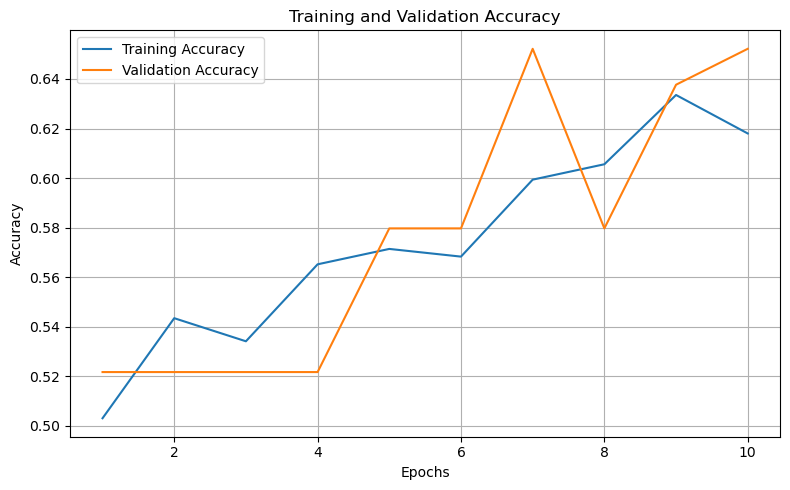

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


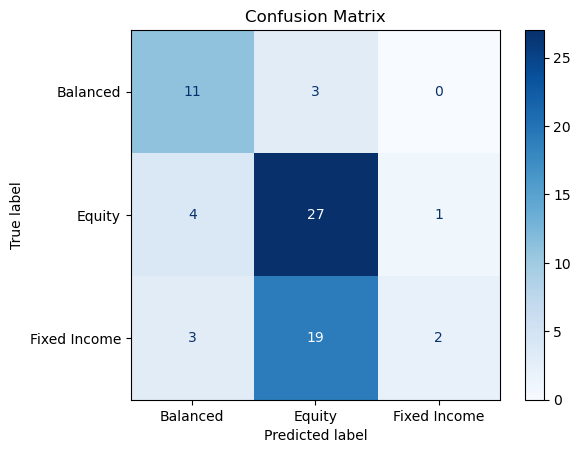




Num_words: 3500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3753 - loss: 1.1765 - val_accuracy: 0.5217 - val_loss: 1.0086
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5102 - loss: 1.0332 - val_accuracy: 0.5217 - val_loss: 1.0008
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5838 - loss: 0.9802 - val_accuracy: 0.5217 - val_loss: 1.0065
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5618 - loss: 0.9997 - val_accuracy: 0.5217 - val_loss: 1.0130
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5482 - loss: 0.9790 - val_accuracy: 0.5217 - val_loss: 0.9963
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5004 - loss: 1.0112 - val_accuracy: 0.5217 - val_loss: 0.9882
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5247 - loss: 1.0164 - val_accuracy: 0.5217 - val_loss: 0.9954
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5226 - loss: 0.9994 - val_accuracy: 0.5217 - val_loss: 0.

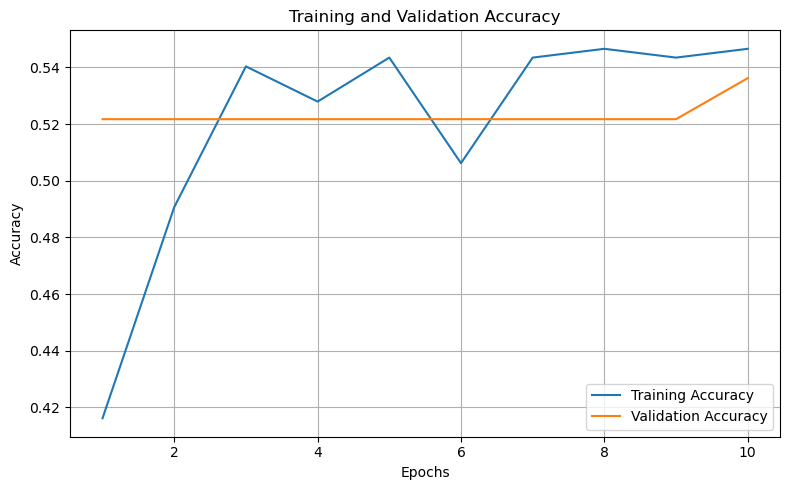

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


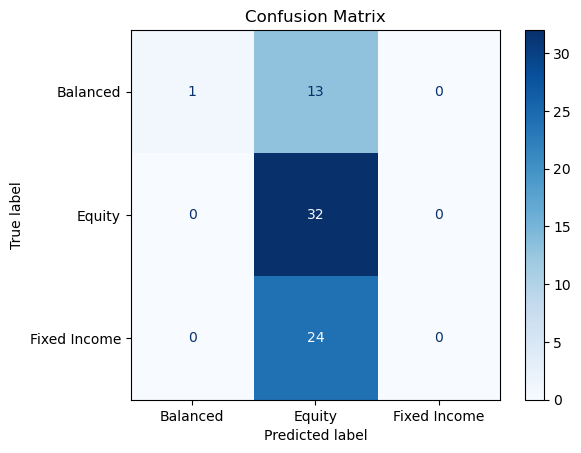




Num_words: 3500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4574 - loss: 1.1125 - val_accuracy: 0.5217 - val_loss: 1.0387
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5316 - loss: 1.0226 - val_accuracy: 0.5217 - val_loss: 0.9976
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5286 - loss: 1.0153 - val_accuracy: 0.5217 - val_loss: 0.9815
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5399 - loss: 0.9763 - val_accuracy: 0.5217 - val_loss: 0.9551
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5459 - loss: 0.9539 - val_accuracy: 0.6377 - val_loss: 0.9465
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5168 - loss: 0.9623 - val_accuracy: 0.5217 - val_loss: 0.9248
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5882 - loss: 0.8872 - val_accuracy: 0.6812 - val_loss: 0.9091
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6391 - loss: 0.8588 - val_accuracy: 0.6957 - val_loss: 0.

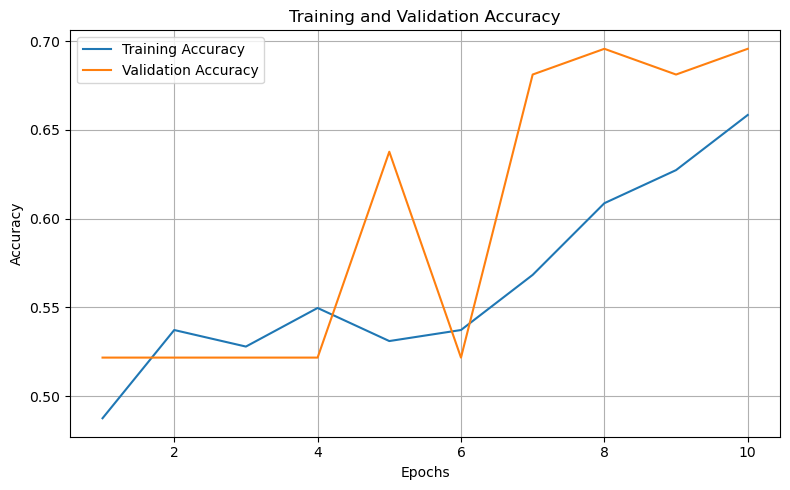

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


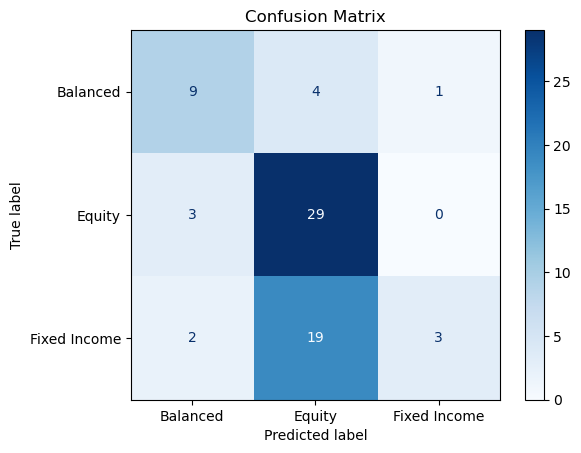




Num_words: 3500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5010 - loss: 1.0994 - val_accuracy: 0.5217 - val_loss: 1.0091
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4881 - loss: 1.0127 - val_accuracy: 0.5217 - val_loss: 0.9633
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5524 - loss: 0.9713 - val_accuracy: 0.5217 - val_loss: 0.9542
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5381 - loss: 0.9343 - val_accuracy: 0.5507 - val_loss: 0.9349
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5620 - loss: 0.9521 - val_accuracy: 0.5217 - val_loss: 0.8976
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5785 - loss: 0.8916 - val_accuracy: 0.6957 - val_loss: 0.9110
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5924 - loss: 0.9384 - val_accuracy: 0.5652 - val_loss: 0.8598
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6071 - loss: 0.8621 - val_accuracy: 0.6812 - val_loss: 0.

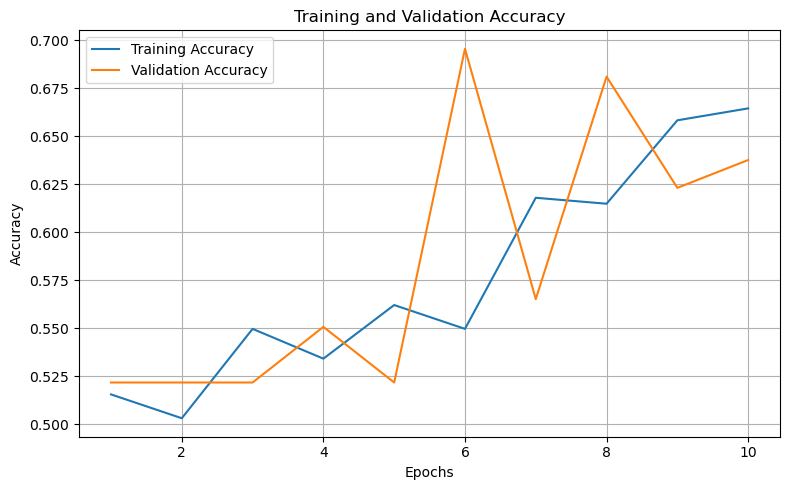

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


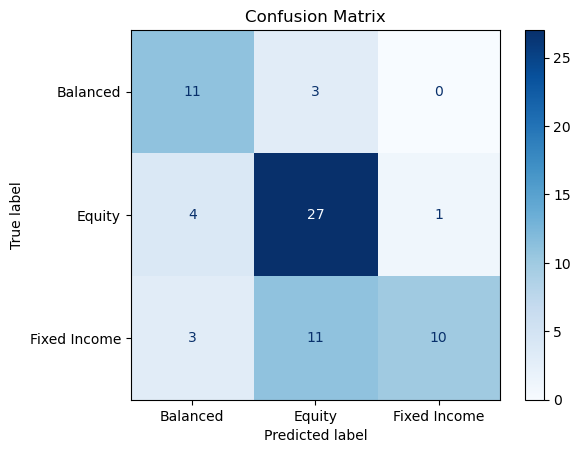




Num_words: 3500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4288 - loss: 1.0675 - val_accuracy: 0.5217 - val_loss: 0.9709
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5157 - loss: 1.0080 - val_accuracy: 0.5217 - val_loss: 0.9694
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5332 - loss: 0.9876 - val_accuracy: 0.5217 - val_loss: 0.9445
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5509 - loss: 0.9386 - val_accuracy: 0.5652 - val_loss: 0.9284
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5724 - loss: 0.9567 - val_accuracy: 0.5217 - val_loss: 0.8894
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5609 - loss: 0.8922 - val_accuracy: 0.6522 - val_loss: 0.8524
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6062 - loss: 0.8363 - val_accuracy: 0.6667 - val_loss: 0.8604
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6599 - loss: 0.7812 - val_accuracy: 0.6667 - val_loss: 0.

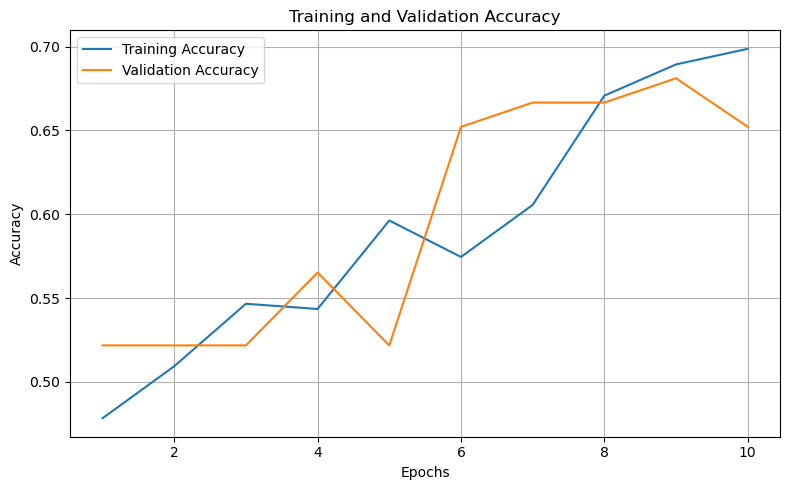

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


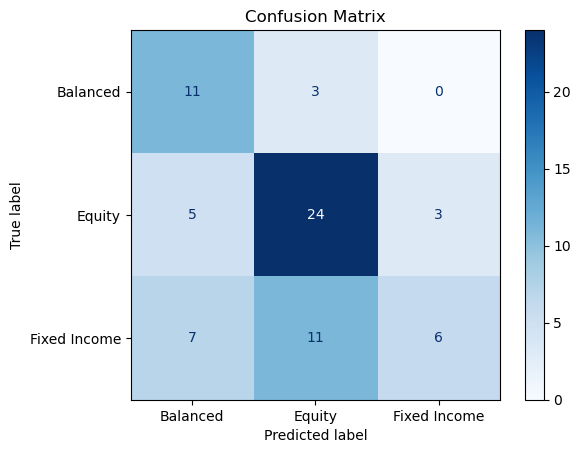




Num_words: 4500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4940 - loss: 1.0910 - val_accuracy: 0.5217 - val_loss: 1.0033
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5335 - loss: 1.0328 - val_accuracy: 0.5217 - val_loss: 0.9966
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5385 - loss: 1.0311 - val_accuracy: 0.5217 - val_loss: 0.9926
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5484 - loss: 1.0117 - val_accuracy: 0.5217 - val_loss: 0.9812
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5269 - loss: 0.9869 - val_accuracy: 0.5217 - val_loss: 0.9743
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5537 - loss: 0.9672 - val_accuracy: 0.5217 - val_loss: 0.9753
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5138 - loss: 0.9936 - val_accuracy: 0.5217 - val_loss: 1.0131
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5313 - loss: 1.0193 - val_accuracy: 0.5652 - val_loss: 0.

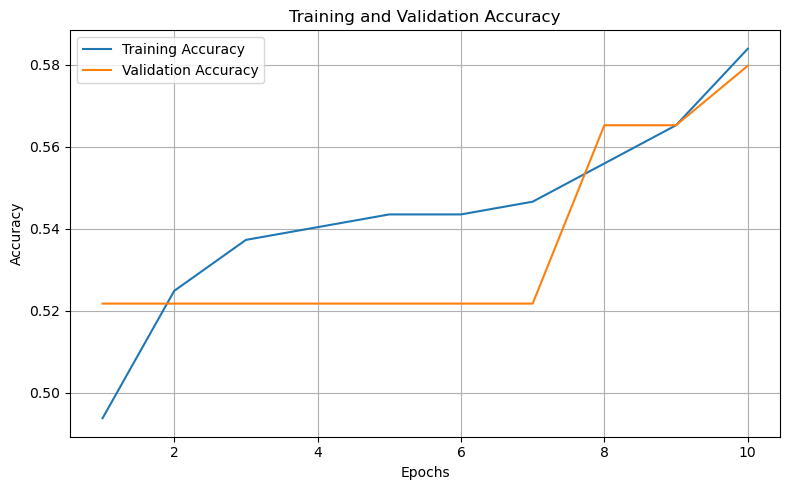

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


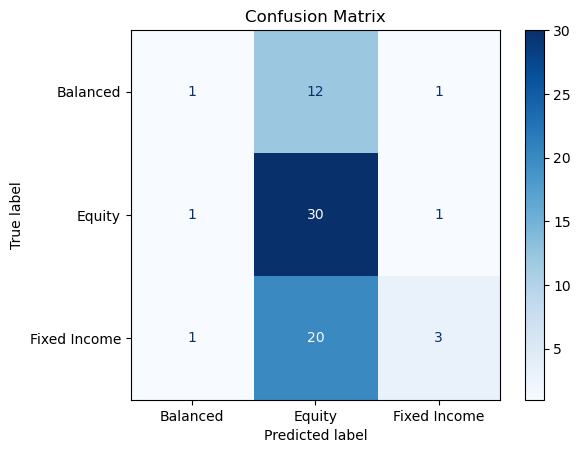




Num_words: 4500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4641 - loss: 1.0721 - val_accuracy: 0.5217 - val_loss: 1.0160
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5755 - loss: 0.9847 - val_accuracy: 0.5217 - val_loss: 0.9781
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5421 - loss: 0.9887 - val_accuracy: 0.5217 - val_loss: 0.9594
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5335 - loss: 0.9890 - val_accuracy: 0.4928 - val_loss: 0.9462
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5817 - loss: 0.9310 - val_accuracy: 0.5942 - val_loss: 0.9072
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5881 - loss: 0.8739 - val_accuracy: 0.6232 - val_loss: 0.8921
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6585 - loss: 0.8597 - val_accuracy: 0.6812 - val_loss: 0.8445
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6275 - loss: 0.8327 - val_accuracy: 0.6957 - val_loss: 0.

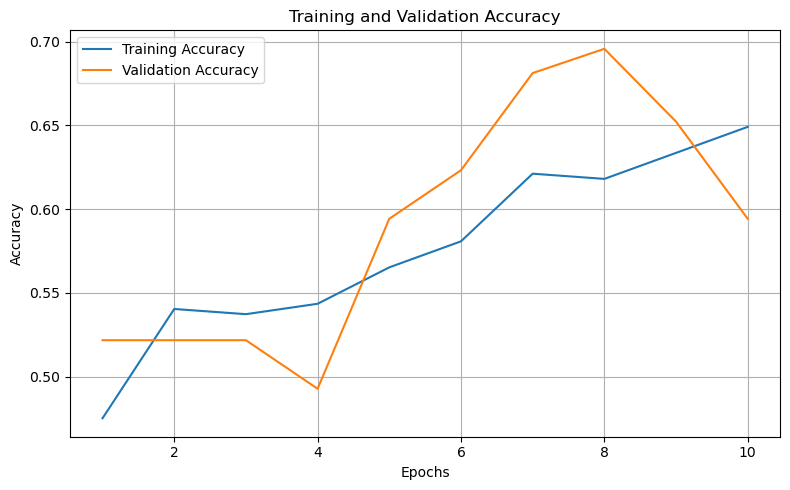

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


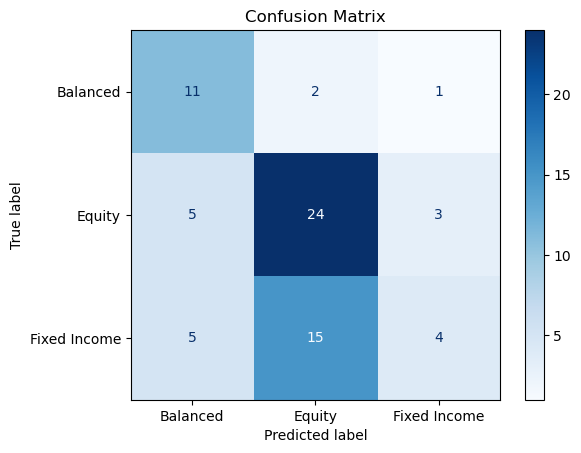




Num_words: 4500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.4850 - loss: 1.0769 - val_accuracy: 0.5217 - val_loss: 0.9917
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5388 - loss: 1.0017 - val_accuracy: 0.5217 - val_loss: 0.9719
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5314 - loss: 0.9665 - val_accuracy: 0.5217 - val_loss: 0.9499
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5302 - loss: 0.9470 - val_accuracy: 0.5217 - val_loss: 0.9055
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5504 - loss: 0.9153 - val_accuracy: 0.5942 - val_loss: 0.8864
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6174 - loss: 0.8782 - val_accuracy: 0.5217 - val_loss: 0.8845
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5933 - loss: 0.8769 - val_accuracy: 0.6812 - val_loss: 0.8317
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6762 - loss: 0.7942 - val_accuracy: 0.6232 - val_loss: 0.

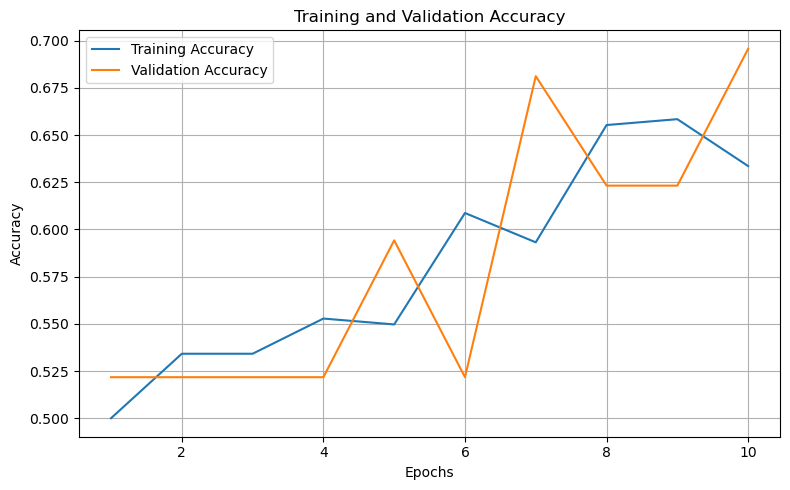

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


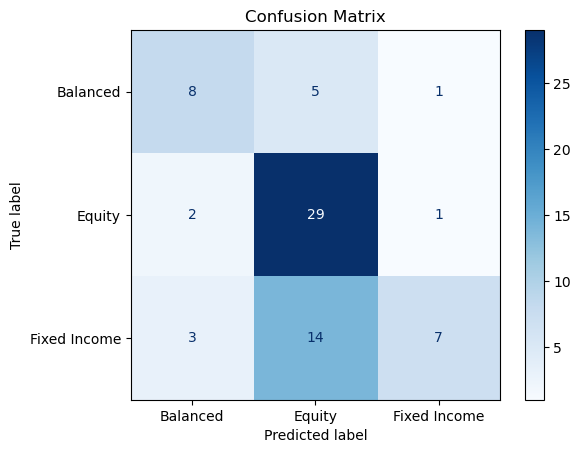




Num_words: 4500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.4716 - loss: 1.0654 - val_accuracy: 0.5217 - val_loss: 0.9793
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5517 - loss: 0.9743 - val_accuracy: 0.5217 - val_loss: 0.9532
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5234 - loss: 0.9736 - val_accuracy: 0.5217 - val_loss: 0.9579
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5613 - loss: 0.9384 - val_accuracy: 0.5507 - val_loss: 0.9308
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6077 - loss: 0.9117 - val_accuracy: 0.5507 - val_loss: 0.8629
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6185 - loss: 0.8420 - val_accuracy: 0.6667 - val_loss: 0.8601
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6624 - loss: 0.7942 - val_accuracy: 0.6232 - val_loss: 0.8460
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6206 - loss: 0.8352 - val_accuracy: 0.6957 - val_loss: 0.

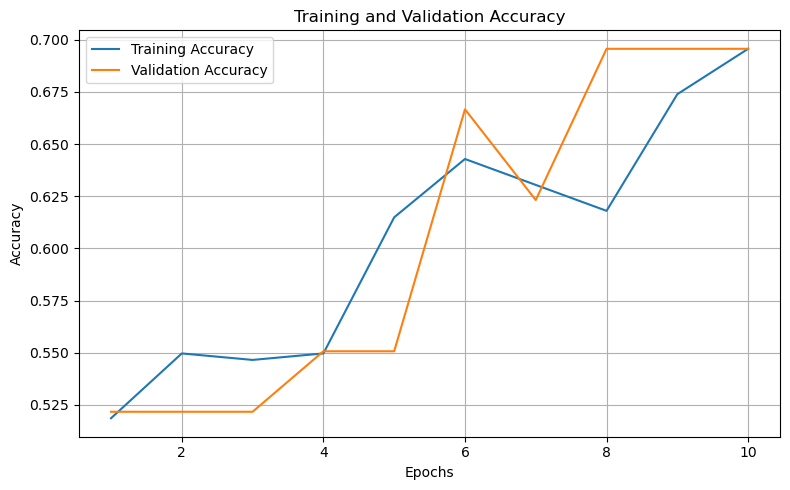

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


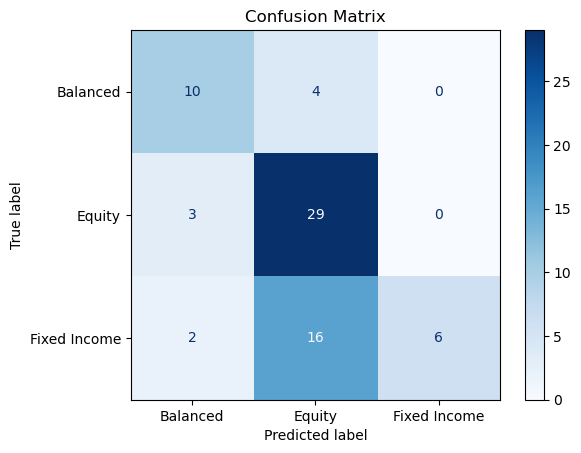

In [152]:
for num_words in [1500, 2500, 3500, 4500]:
    for maxlen in [100, 150, 250, 350]:
        print()
        print()
        print()
        print("Num_words: " + str(num_words))
        print("maxlen: " + str(maxlen))
        run_CNN(num_words, maxlen, 50)